In [1]:
import cv2
from PIL import Image

In [2]:
import os

In [3]:
import tensorflow as tf
from keras.models import load_model
from matplotlib import pyplot as plt
import numpy as np

In [4]:
import keras

In [5]:
import matplotlib

In [6]:
from tensorflow import keras

In [7]:
from focal_loss import SparseCategoricalFocalLoss

In [8]:
from tensorflow.keras.utils import to_categorical

In [9]:
def ratingOneImage(model,img_path):
    image = cv2.imread(img_path)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(image,(400,400))
    img_reshaped = np.reshape(img_resized,(1,400,400,3))
    pred = model.predict(img_reshaped)
    arr = np.array(pred[3][0])
    pred_arr = np.argmax(arr,axis=2)
    pred_cat = to_categorical(pred_arr)
    pred_crack = pred_cat[:,:,1]
    pred_pothole = pred_cat[:,:,2]
    # Viz Prediction
    fig,axs = plt.subplots(1,2,figsize=(10,5))
    axs[0].imshow(img_resized)
    axs[1].imshow(pred_cat)
    # Count pixels of pothole, crack count_nonzero
    # % area of potholes =  (NOP(pothole)/NOP(total))*100
    # % area of cracks =  (NOP(craks)/NOP(total))*100
    crack_pixel = np.count_nonzero(pred_crack)
    pothole_pixel = np.count_nonzero(pred_pothole)
    
    crack_area = (crack_pixel/160000)*100
    pothole_area = (pothole_pixel/160000)*100
    #print(pothole_pixel,crack_pixel)
    
    # Rating logic
    # crack rating
    if(crack_area<=10):
        crack_rating = round(3-(crack_area/5.25),1)
    else:
        crack_rating=1
    
    # Pothole rating
    if(pothole_area<0.1):
        pothole_rating=round(3-pothole_area*10,1)
    elif(pothole_area<=1):
        pothole_rating=round(2.1-pothole_area,1)
    else:
        pothole_rating=1
    
    # Applying Weightage (weighted_rating = wr)
    wr_crack = crack_rating*1
    wr_pothole = pothole_rating*0.5
    
    # Weighted Rating Value (Avg)
    rating = round(sum([wr_crack,wr_pothole])/2,1)
    
    if(rating<=1):
        overall_condition='Poor'
    elif(rating>=1.1 and rating<=2):
        overall_condition='Fair'
    else:
        overall_condition='Good'
    
    if(pothole_area<=0.1):
        pothole_condition='Good'
    elif(pothole_area>0.1 and pothole_area<=1):
        pothole_condition='Fair'
    elif(pothole_area>1):
        pothole_condition='Poor'
    
    if(crack_area<=5):
        crack_condition='Good'
    elif(crack_area>5 and crack_area<=10):
        crack_condition='Fair'
    elif(crack_area>10):
        crack_condition='Poor'
    
    return {'Crack Area':crack_area,'Pothole Area':pothole_area,
            'Pothole Rating':wr_pothole,'Pothole Condition':pothole_condition,
            'Crack Rating':wr_crack,'Crack Condition':crack_condition,
            'Overall Rating':rating,'Overall Condition':overall_condition,
            'Crack Pixel':crack_pixel,'Pothole Pixel':pothole_pixel
           }
    
#     return pred_arr

In [10]:
lim_ds = load_model('limited_dataset_training_unet3plus.hdf5',compile=False)

1/1 [==============================] - 4s 4s/step


{'Crack Area': 0.116875,
 'Pothole Area': 18.469375,
 'Pothole Rating': 0.5,
 'Pothole Condition': 'Poor',
 'Crack Rating': 3.0,
 'Crack Condition': 'Good',
 'Overall Rating': 1.8,
 'Overall Condition': 'Fair'}

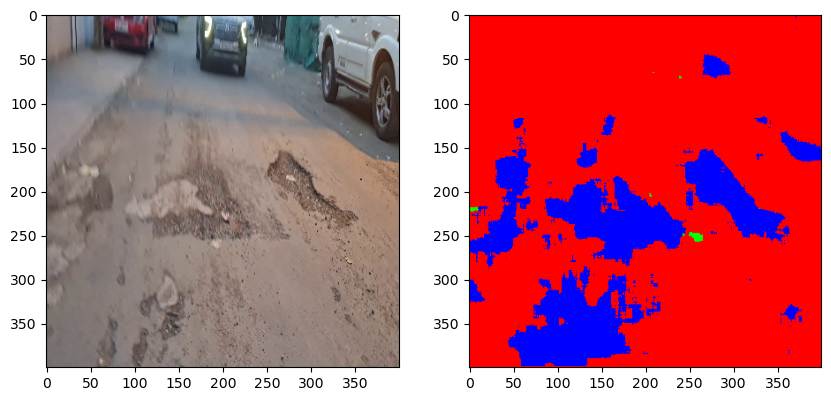

In [12]:
ratingOneImage(lim_ds,'frame_0023.jpg')

In [11]:
def extract_frames(video_path, output_dir, num_frames):
    # Open the video file
    video = cv2.VideoCapture(video_path)

    # Get total number of frames in the video
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate frame interval
    frame_interval = total_frames // num_frames

    frames = []
    count = 0
    frame_number = 0

    while count < num_frames:
        # Set the frame number to be read
        frame_number = frame_interval * count

        # Set the current frame position
        video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

        # Read the next frame
        ret, frame = video.read()

        if ret:
            # Resize the frame if needed
            # frame = cv2.resize(frame, (new_width, new_height))

            # Convert the frame to RGB format
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Save the frame to the specified directory
            frame_path = os.path.join(output_dir, f"frame_{count}.jpg")
            cv2.imwrite(frame_path, frame)

            frames.append(frame_path)
            count += 1
        else:
            break

    # Release the video file
    video.release()

    return frames

In [12]:
video_path = "input (5 sec).mp4"
output_dir = "demo folder"
num_frames = 5

frames = extract_frames(video_path, output_dir, num_frames)


In [13]:
def ratingVid(model,video_path,output_dir, num_frames):
    # Creating frames from video
    extract_frames(video_path, output_dir, num_frames)
    
    # Looping through the frames to calculate rating
    imgs = os.listdir(output_dir)
    total_crack_pixel, total_pothole_pixel = 0,0
    for img in imgs:
        img_path = output_dir+"\\"+img
        rating_obj = ratingOneImage(model,img_path)
        total_crack_pixel+=rating_obj['Crack Pixel']
        total_pothole_pixel+=rating_obj['Pothole Pixel']
    
    crack_area = (total_crack_pixel/(160000*num_frames))*100
    pothole_area = (total_pothole_pixel/(160000*num_frames))*100
    #print(pothole_pixel,crack_pixel)
    
    # Rating logic
    # crack rating
    if(crack_area<=10):
        crack_rating = round(3-(crack_area/5.25),1)
    else:
        crack_rating=1
    
    # Pothole rating
    if(pothole_area<0.1):
        pothole_rating=round(3-pothole_area*10,1)
    elif(pothole_area<=1):
        pothole_rating=round(2.1-pothole_area,1)
    else:
        pothole_rating=1
    
    # Applying Weightage (weighted_rating = wr)
    wr_crack = crack_rating*1
    wr_pothole = pothole_rating*0.5
    
    # Weighted Rating Value (Avg)
    rating = round(sum([wr_crack,wr_pothole])/2,1)
    
    if(rating<=1):
        overall_condition='Poor'
    elif(rating>=1.1 and rating<=2):
        overall_condition='Fair'
    else:
        overall_condition='Good'
    
    if(pothole_area<=0.1):
        pothole_condition='Good'
    elif(pothole_area>0.1 and pothole_area<=1):
        pothole_condition='Fair'
    elif(pothole_area>1):
        pothole_condition='Poor'
    
    if(crack_area<=5):
        crack_condition='Good'
    elif(crack_area>5 and crack_area<=10):
        crack_condition='Fair'
    elif(crack_area>10):
        crack_condition='Poor'
    
    return {'Crack Area':crack_area,'Pothole Area':pothole_area,
            'Pothole Rating':wr_pothole,'Pothole Condition':pothole_condition,
            'Crack Rating':wr_crack,'Crack Condition':crack_condition,
            'Overall Rating':rating,'Overall Condition':overall_condition,
           }
    

1/1 [==============================] - 2s 2s/step


{'Crack Area': 0.111875,
 'Pothole Area': 13.218374999999998,
 'Pothole Rating': 0.5,
 'Pothole Condition': 'Poor',
 'Crack Rating': 3.0,
 'Crack Condition': 'Good',
 'Overall Rating': 1.8,
 'Overall Condition': 'Fair'}

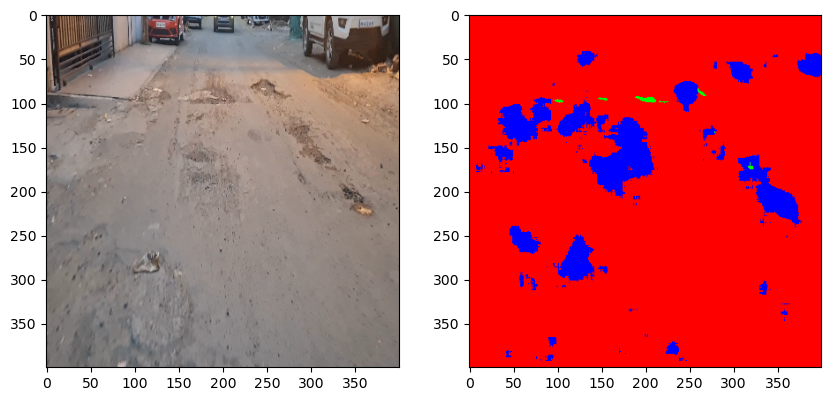

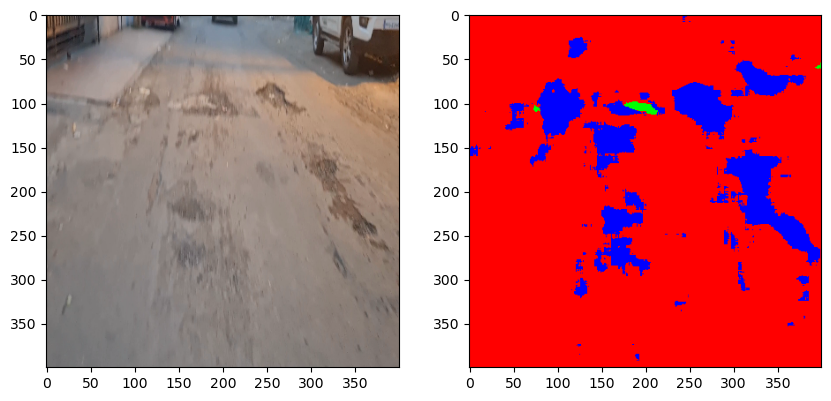

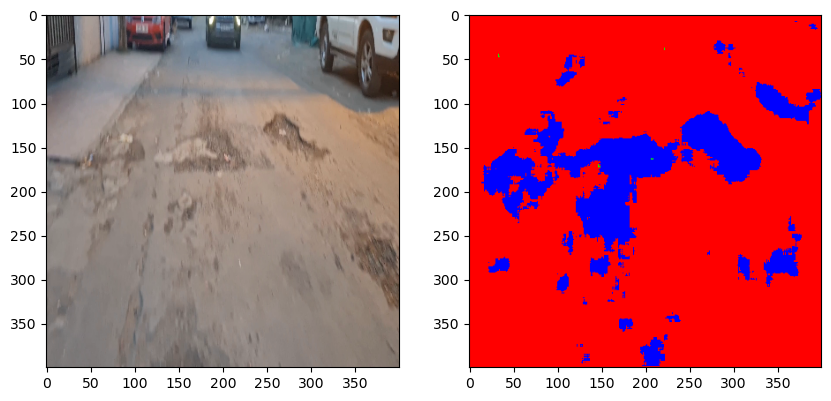

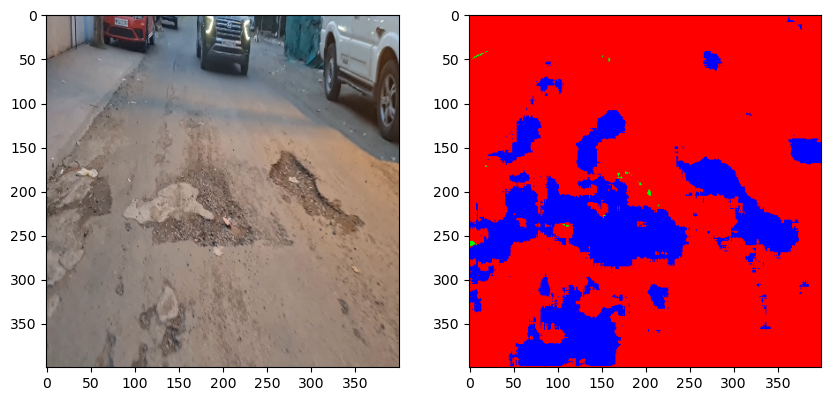

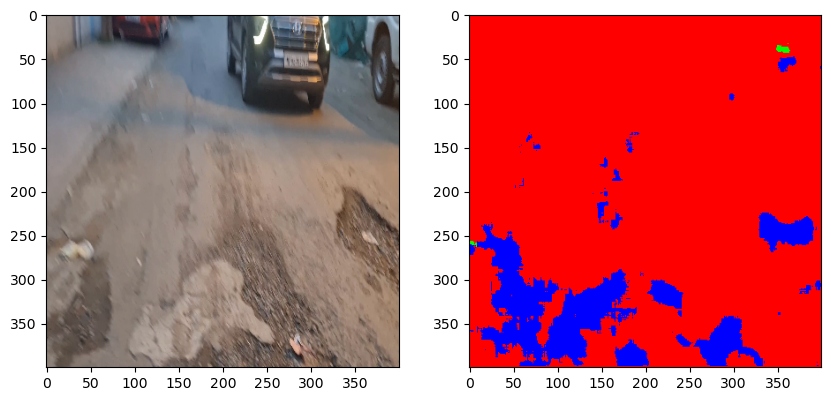

In [18]:
video_path = "input (5 sec).mp4"
output_dir = "demo folder"
num_frames = 5
ratingVid(lim_ds,video_path,output_dir,num_frames=5)